### 1-D elastic wave simulation, SEM

In [172]:
%matplotlib notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec  


from Lagrange import Lagrange 
from Time_Int import Time_Int
from myplot import myplot
import functions as fnc 

#### Domain characteristics

In [174]:
L = 8000              # x domain
nt = 7500             # number of time points
c0 = 3000             # acoustic wave velocity
rho0 = 2500           # density
mu0 = rho0 * c0**2    # shear modulus
freq = 2              # central frequency of the source
N = 2                 # degree of polynomyal 
xsrc = L//2           # source position
xrec = (3*L)//4       # receiver position
lmin = c0 / freq      # minimum wavelength
he = lmin / 20        # length of elements
ne = int(L / he)      # number of elements
t0 = 1.5*np.sqrt(6)/(np.pi*freq) # time shift of source

dt = 0.0005           # time step
cfl = c0*dt/he
print('CFL is: ', cfl)

# Jacobian and its inverse
J = he/2
Ji = 1/J
iplot = 10            # step for showing the simulation

CFL is:  0.02


#### Calling Functions
+ Lagrange polynomials
+ Derivative of Lagrange polynomials
+ GLL points

In [175]:
Lag = Lagrange(N)   # Lagrange polynomials 
x , w = Lag.gll()   # GLL points and weights
D = Lag.deriv()     # first derivative of Lagrange polynomials. 

C  = fnc.connect_mat(ne, N) # connectivity matrix

#### Defining spatial coordinate and parameters
+ Global coodrinate
+ Defining vectors of $\rho, \mu, c$

<IPython.core.display.Javascript object>


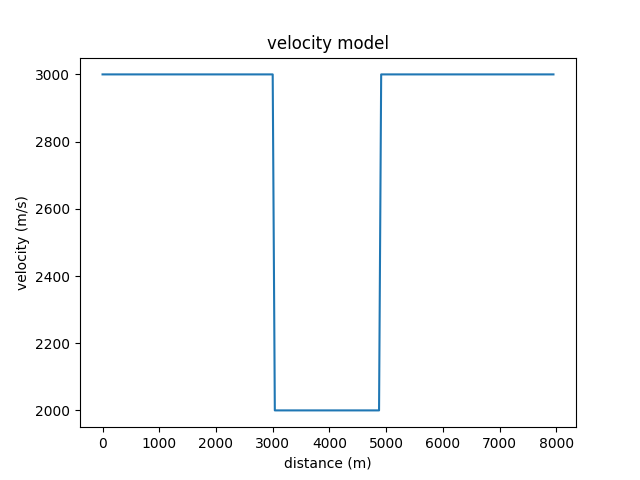

In [176]:
# physical coordinate
nep = ne * N + 1
nep = nep
X = np.zeros(nep)

for i in range(ne):
    for j in range(N+1):
        X[i * N + j] = i * he + (x[j] + 1)/2 * he
        
# Receiver and souce locations
isrc = int((xsrc/X[-1])*nep) + 1  # source position
irec = int((xrec/X[-1])*nep)      # receiver position

# spatial elastic constants   
c = np.zeros(nep)
c = c + c0                        # velocity
# ----------------------------------------------------
#            24% of domain is low-velocity zone
ratd = int(0.12 * nep)
c[len(c)//2 - ratd: len(c)//2 + ratd] -= 1000 
plt.figure()
plt.plot(X, c)
plt.title('velocity model')
plt.xlabel('distance (m)')
plt.ylabel('velocity (m/s)')
plt.show()
plt.savefig('velocity_profile.png')
# ----------------------------------------------------
rho = np.zeros(nep)
rho = rho + rho0             # density
mu = np.zeros(nep)
mu = rho * c**2              # shear modulus

#### Mass Matrix

<IPython.core.display.Javascript object>


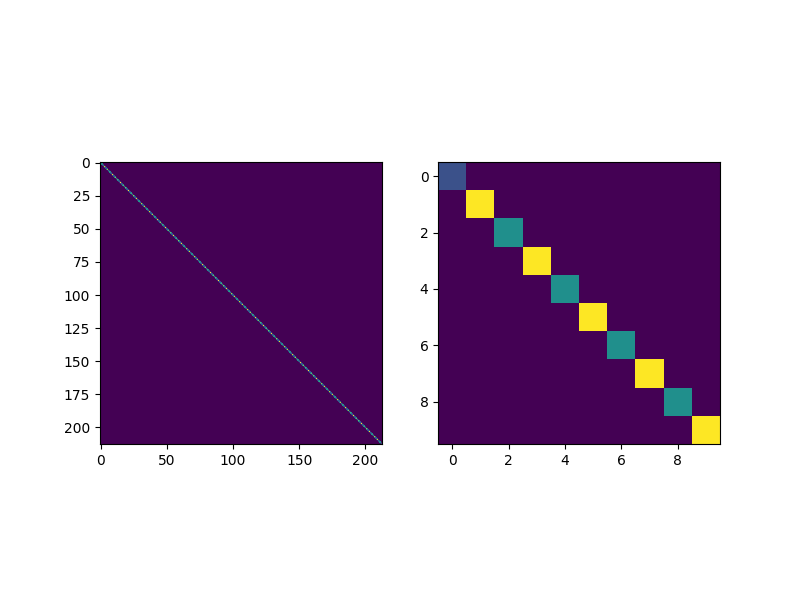

In [177]:
m = np.zeros(nep)
for i in range(ne):
    ind = C[:,i]
    for j in range(N+1):
        d = int(ind[j]-1)
        m[d] = m[d] + rho[d] * w[j] * J

Minv = np.diag(1/m)

### plot ------
plt.subplots(1,2, figsize=(8,6))
plt.subplot(1,2,1)
plt.imshow(np.diag(m))
plt.subplot(1,2,2)
plt.imshow(np.diag(m)[:10, :10])
plt.show()

#### Stiffness Matrix

<IPython.core.display.Javascript object>


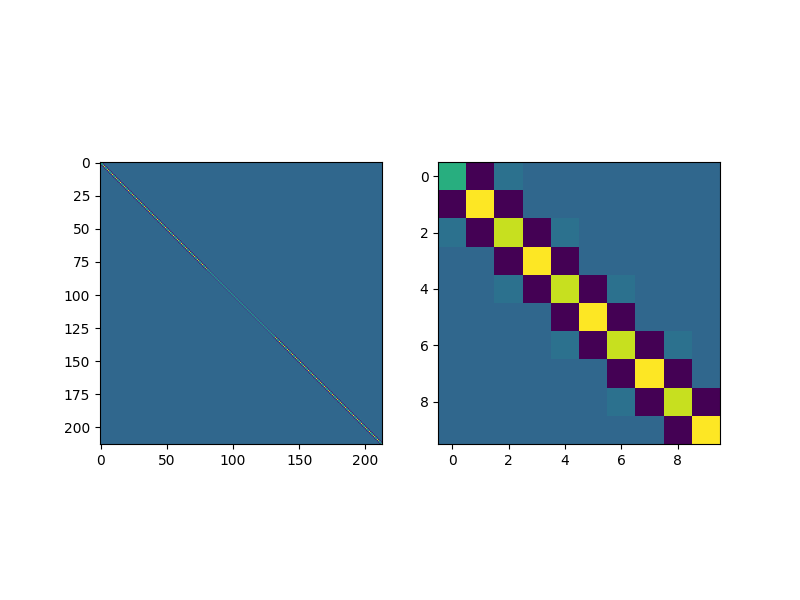

In [178]:
K = np.zeros((nep, nep))

for el in range(ne):
    ind = C[:,el]
    ind = ind.astype(int)
    se = np.zeros((N+1, N+1))
    for i in range(N+1):
        for j in range(N+1):
            for k in range(N+1):
                se[i, j] = se[i, j] + mu[ind[k]-1] * w[k] * D[i, k] * D[j, k] * Ji
    l1, l2 = ind[0]-1, ind[-1]
    K[l1:l2, l1:l2] = K[l1:l2, l1:l2] + se

### plot --------------
plt.subplots(1,2, figsize=(8,6))
plt.subplot(1,2,1)
plt.imshow(K)
plt.subplot(1,2,2)
plt.imshow(K[:10, :10])
plt.show()

### Starting the simualtion
<pre>
Time integration schemes are:
'cfd'          :  centered finite difference
'newmark'      :  Newmark scheme


And boundary conditions are:
'free'         : Free boundary conditions
'rigid'        : Rigid boundary conditions
'periodic'     : Periodic boundary conditions
'absorbing'    : Absorbing boundary conditions
</pre>

In [181]:
# Matrix for saving wavefield
mat = np.zeros((nt, nep))

# Sythetic seismogram
seis = np.zeros(nt)

# -------------------- initialization of time integration----------------#
# -------------------------- calling Time_Int class ---------------------#
mode = 'newmark'     
bd = 'absorbing'     
Integ = Time_Int(K, m, c, rho, J, nep, dt, isrc, mode, bd)
time, src = Integ.source(nt, freq, t0, d_amp=0, src_type='gauss') 
# newmark_acc_type='average' is defualt ('average','linear')
# src_type can be also 'dirac', for which 'd_amp' is the amplitude

# Initializing vectors for corresponding time integration scheme
Integ.scheme_init()

#### Plotting

<IPython.core.display.Javascript object>


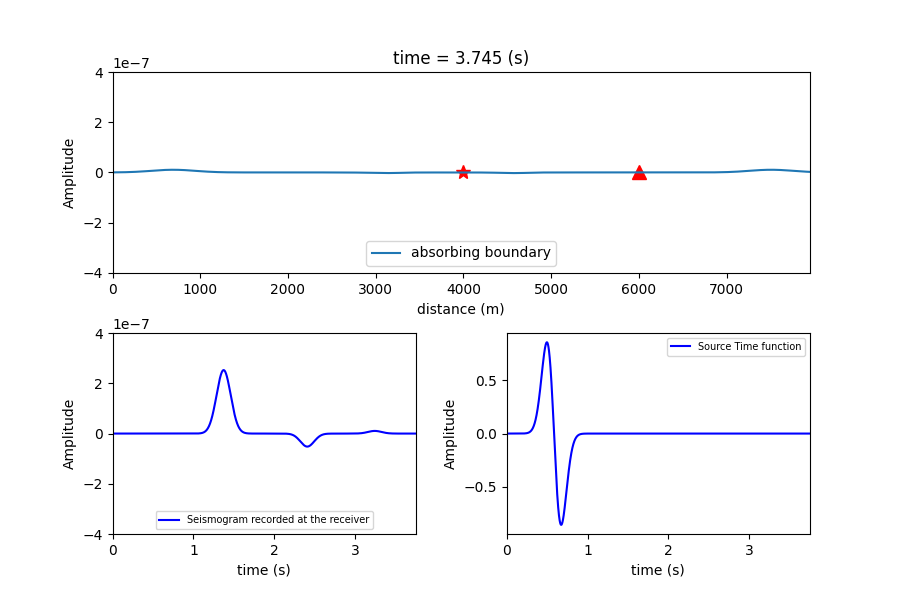

In [182]:
ax1, up1, ax2, up2 = myplot(X, Integ.u, time, src, seis, xsrc, xrec, bd)
    
for it in range(nt):
    
    # --------- Numerical simulation
    Integ.it = it
    u = Integ.run()
    
    # --------- Recording at the receiver
    seis[it] = u[irec]
       
    # ---------- saving wavefiled
    mat[it,:] = u
    
    # displaying the result
    if  it % iplot == 0:
        up1.set_ydata(u)
        #ax1.set_ylim([-1.1 * np.max(abs(u)), 1.1*np.max(abs(u))])
        ax1.set_ylim([-.4 * 1e-6, .4 * 1e-6])
        ax1.set_title('time = %.3f (s)' %(it*dt))

        
        up2.set_ydata(seis)
        ax2.set_ylim([-.4* 1e-6, .4 * 1e-6])
        plt.gcf().canvas.draw()
        

<IPython.core.display.Javascript object>


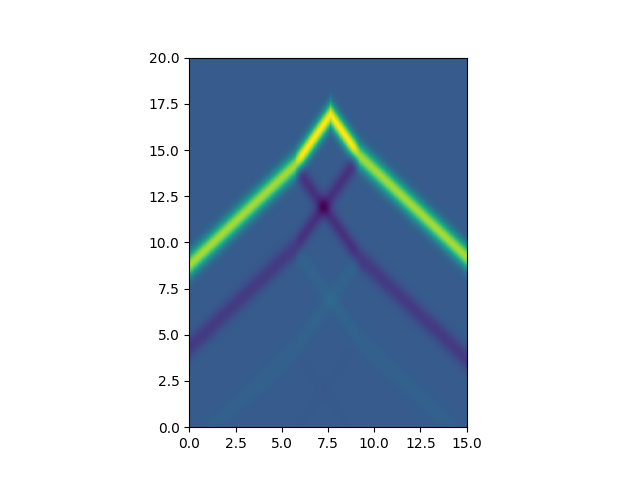

In [183]:
# showing the wavefield
plt.figure()
plt.imshow(mat, extent=[0,15,0,20])
plt.show()
#plt.savefig('wavefiled_abc.png')